In [1]:
%pip install --upgrade pip
%pip install numpy networkx scipy joblib
import Sequencer

# Import libraries

In [2]:
%pip install --upgrade pip
%pip install numpy networkx scipy joblib matplotlib pandas astropy requests json

# imports
%matplotlib inline


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.table import Table
from astropy.table import QTable
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization import quantity_support
from matplotlib.colors import LogNorm
import glob
import requests
import matplotlib as mpl
import matplotlib.cm as cm
import requests
import json


In [3]:
path_fits = 'dataset/fits/'
path_json = 'dataset/fits.json'

PATH_FILE = "PATH_FILE"
SPEC = "SPEC"
PLATE = "PLATE"
REDSHIFT = "REDSHIFT"

fits_json_object = json.load(open(path_json))
len(fits_json_object)

1937

In [5]:
spectra_list = []
wavelength_list = []

for f in fits_json_object:
    if float(f[REDSHIFT]) > 0.1 and f[REDSHIFT] <= 0.2:
        #opens fits file
        h = fits.open(f[PATH_FILE])
        data = h[1].data
        h1 = h[1].header
        name = (h.filename())[-25:-5]
        if name == 'spec-2013-53818-0635.fits':
            continue
        if name == 'spec-0958-52410-0606.fits':
            continue
        # Redshift value for AGN processed
        z = f[REDSHIFT]
        # flux and wavelenght from fits file
        lamb = 10**data['loglam']
        flux_raw = data['flux']
        w = WCS(h1, naxis=1, relax=False, fix=False)
        # rest-frame wavelength
        lambd = lamb/(1+z)
        #common wavelength grid from 4000˚ A to 7000
        lambda_bin=np.arange(3000)+4000
        #interpolate flux to common wavelengh 
        flux_bin = sp.interpolate.interp1d(lambd, flux_raw, kind='cubic')(lambda_bin)
        # logarithmic wavelength scale
        lam = w.wcs_pix2world(np.arange(len(flux_bin)), 0)[0]
        log_lam_raw = np.log(lamb)
        # logarithmic rebinning
        log_lam = np.linspace(min(log_lam_raw), max(log_lam_raw), num=len(lam))

        # remove continuum of spectra
        def fit_polynom(log_lam, a0, a1, a2, a3, a4, a5):
            """fit func = 2 nd order polynom"""
            return a0+a1*log_lam+a2*(log_lam)**2+a3*(log_lam)**3+a4*(log_lam)**4+a5*(log_lam)**5
        # intitialize fit paramters
        init_fit_param = [0, 0, 0, 0 ,0, 0]
        # fit data using scipy.curve_fit()
        fit_params, fit_covariances = curve_fit(fit_polynom, log_lam, flux_bin, p0=init_fit_param, maxfev=5000)
        # remove continuum by dividing flux by fit polynomial
        flux = (flux_bin - (fit_polynom(log_lam, *fit_params))) -1
        fflux = flux / lambd.sum()

        spectra_list.append(fflux)
        wavelength_list.append(lambda_bin)
        
        
print("number of stellar spectra: %s" % len(spectra_list))
print("length of each spectrum: %s" % len(spectra_list[0]))

number of stellar spectra: 452
length of each spectrum: 3000


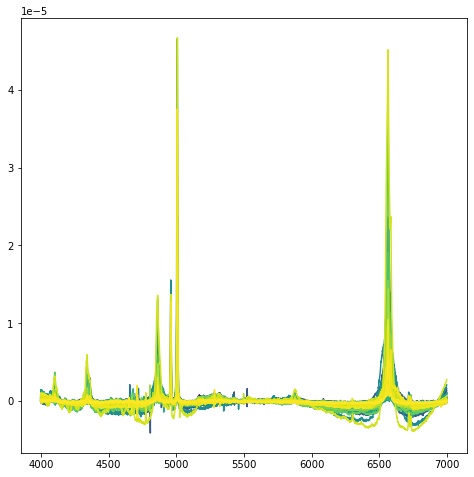

In [6]:
########################## ploting option ################################################
norm = mpl.colors.Normalize(vmin=0, vmax=len(spectra_list)-1)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(5, figsize=(8, 8))
for i in range(0, len(spectra_list), 5):
    plt.plot(wavelength_list[i], spectra_list[i], color=m.to_rgba(i))

(3000,) (452, 3000)


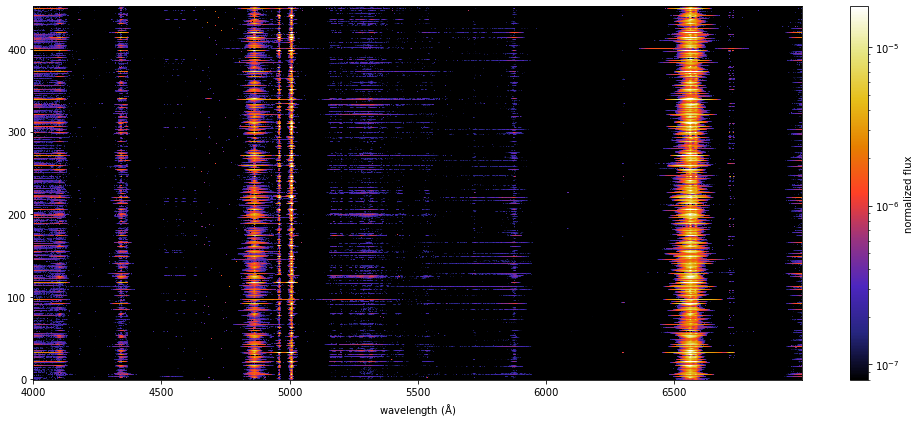

In [7]:
# load the spectra and construct the wavelength range 
wavelength = np.arange(4000, 7000, 1)
spectra_matrix = np.asarray(spectra_list)
print(wavelength.shape, spectra_matrix.shape)

indices_for_plot = np.arange(len(spectra_matrix))
X, Y = np.meshgrid(wavelength, indices_for_plot)

plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, spectra_matrix.clip(0.00000008, 0.000018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

In [9]:
## Normalizing dataset (Min-Max normalization)
spectrum = spectra_matrix.data
n1 = spectrum - np.min(spectrum)
n2 = np.max(spectrum) - np.min(spectrum)
norm_spectrum = n1/n2
#norm_spectrum = norm_spectrum + 1

In [12]:
print('avg', np.median(norm_spectrum))
print('max', np.max(norm_spectrum))
print('min', np.min(norm_spectrum))

avg 0.03683853461238684
max 1.0
min 0.0


In [24]:
#Parametros del secuenciador, tanto metricas como escalas
estimator_list = ['EMD','energy', 'L2']
scale_list = [[1,2, 8, 16], [1,2, 8, 16], [1,2, 8, 16]]

In [25]:
seq = Sequencer(wavelength, norm_spectrum, estimator_list, scale_list)
output_path = 'dataset/fits/'
final_elongation, final_sequence = seq.execute(output_path, to_average_N_best_estimators=True, 
                                              number_of_best_estimators=2,
                                              to_use_parallelization=True)
print("resulting elongation for the Sequencer: ", final_elongation)

# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("Intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   elongation_list[i]))

# order the input dataset according to the detected sequence
objects_list_ordered = spectra_matrix[final_sequence]

Parallelization is ON. Number of cores: 16
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 5.895209550857544 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 5.615478277206421 seconds
calculating the distance matrices for estimator: EMD, scale: 8
finished calculating this distance matrix list, it took: 12.477697849273682 seconds
calculating the distance matrices for estimator: EMD, scale: 16
finished calculating this distance matrix list, it took: 23.05091118812561 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 4.616826295852661 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 5.55694317817688 seconds
calculating the distance matrices for estimator: energy, scale: 8
finished

C:\Users\davos\AppData\Local\Temp/ipykernel_28320/533716621.py:893: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ordering_bfs = numpy.array(ordering_bfs).astype(numpy.int)


in estimator: EMD, scale: 2
in estimator: EMD, scale: 8
in estimator: EMD, scale: 16
in estimator: energy, scale: 1
in estimator: energy, scale: 2
in estimator: energy, scale: 8
in estimator: energy, scale: 16
in estimator: L2, scale: 1
in estimator: L2, scale: 2
in estimator: L2, scale: 8
in estimator: L2, scale: 16
dumped the elongations to the file: dataset/fits//elongations.pkl
dumped the full weighted distance matrix to the file: dataset/fits//weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='dataset/fits//sparse_distance_matrix.pkl'>


C:\Users\davos\AppData\Local\Temp/ipykernel_28320/533716621.py:1021: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the final sequences and elongation to the file: <_io.BufferedWriter name='dataset/fits//final_products.pkl'>
resulting elongation for the Sequencer:  26.33008653770851
Intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 21.27149737645861
metric=EMD, scale=2, elongation: 26.33008653770851
metric=EMD, scale=8, elongation: 18.028212859268542
metric=EMD, scale=16, elongation: 10.296704910329705
metric=energy, scale=1, elongation: 19.640809773670608
metric=energy, scale=2, elongation: 21.14204322969692
metric=energy, scale=8, elongation: 15.850634348813532
metric=energy, scale=16, elongation: 9.673427833033129
metric=L2, scale=1, elongation: 9.225360247474352
metric=L2, scale=2, elongation: 9.514958101652441
metric=L2, scale=8, elongation: 8.629630354765446
metric=L2, scale=16, elongation: 8.811574907980264


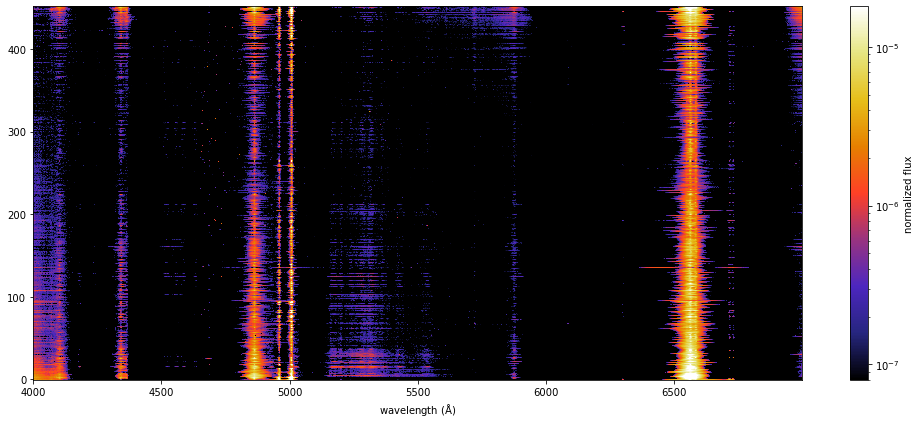

In [26]:
# plot the ordered dataset
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, objects_list_ordered.clip(0.00000008, 0.000018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

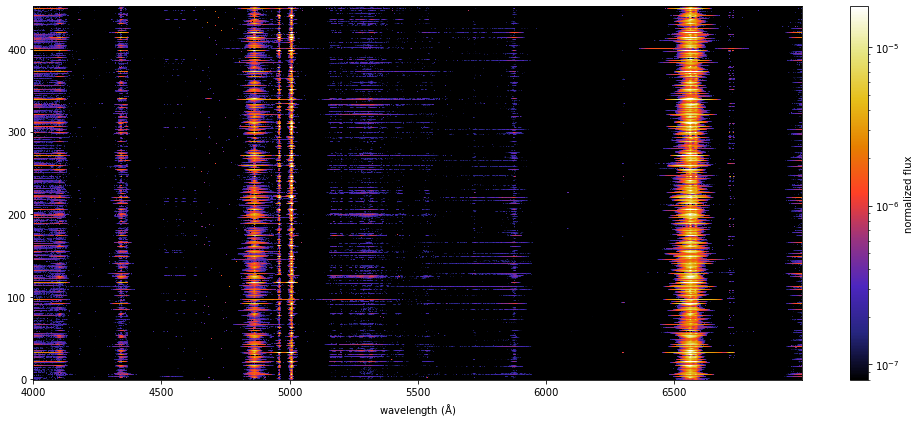

In [27]:
# comparison original
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, spectra_matrix.clip(0.00000008, 0.000018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

In [28]:
final_mst = seq.return_final_MST()
type(final_mst)

networkx.classes.graph.Graph

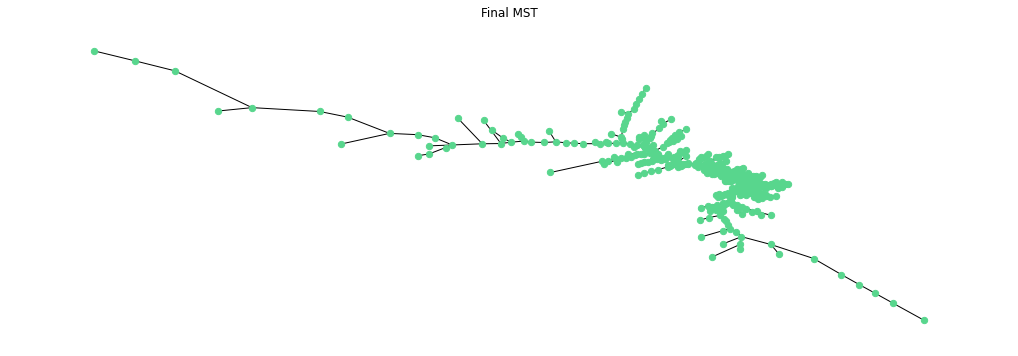

In [29]:
plt.figure(1, figsize=(18, 6))

plt.title("Final MST")
pos = nx.kamada_kawai_layout(final_mst)
nx.draw(final_mst, pos, node_color="#58D68D", node_size=40)